In [1]:
#%%
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob as gb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
#%%
# Loading labels
dataset = "/kaggle/input/ham1000-segmentation-and-classification/"
label_path = dataset + "GroundTruth.csv"
mask_dir = dataset+"masks/"
images_dir = dataset + "images/"
img_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])


In [2]:
#%%
image_names = [os.path.splitext(f)[0] for f in img_files]    # ('ISIC_0024306', '.jpg')
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]    # ('ISIC_0024306_segmentation', 'png')

missing_masks = [f for f in image_names if f not in mask_names]

if len(missing_masks) == 0:
    print('No missing masks found.')
else:
    print(f"There are {len(missing_masks)} missing masks found:")
    print(missing_masks)
#%%
len(img_files), len(mask_files)
#%%


No missing masks found.


(10015, 10015)

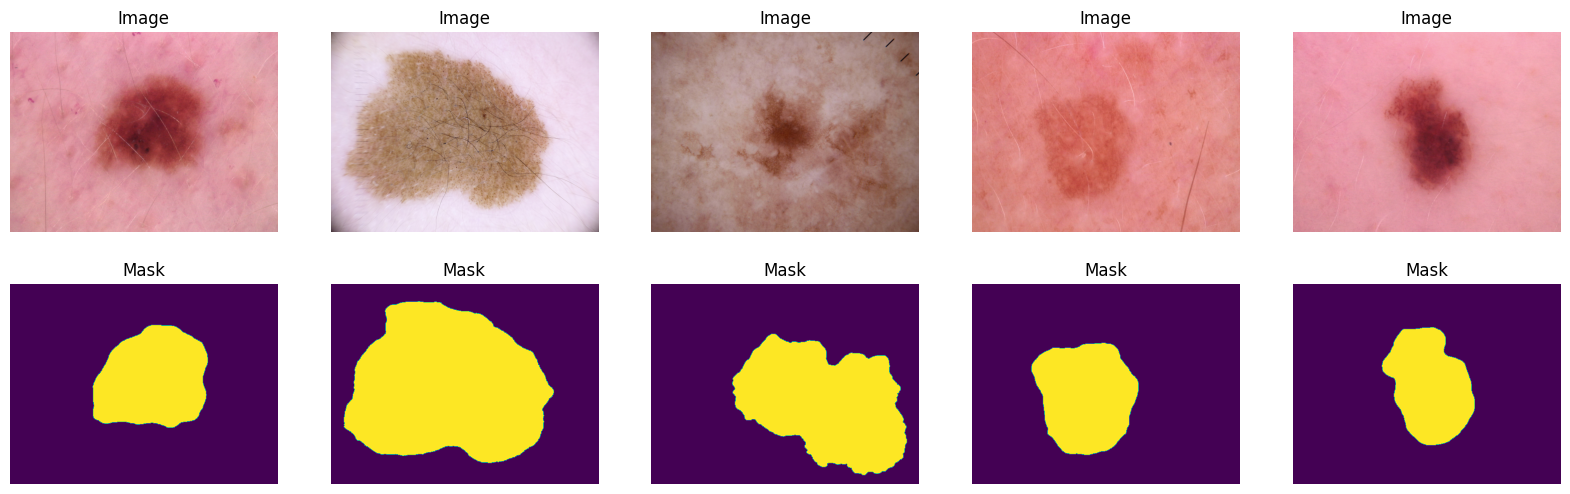

In [3]:


def display_image_and_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

plt.show()
#%%
display_image_and_mask(n=5, seed=42)


In [4]:
#%%
def display_image_with_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img_np = np.array(Image.open(img_path))
        mask_np = np.array(Image.open(mask_path))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='Reds', alpha=0.5)
        axs[i].set_title('Image with Mask')
        axs[i].axis('off')

plt.show()
#%%


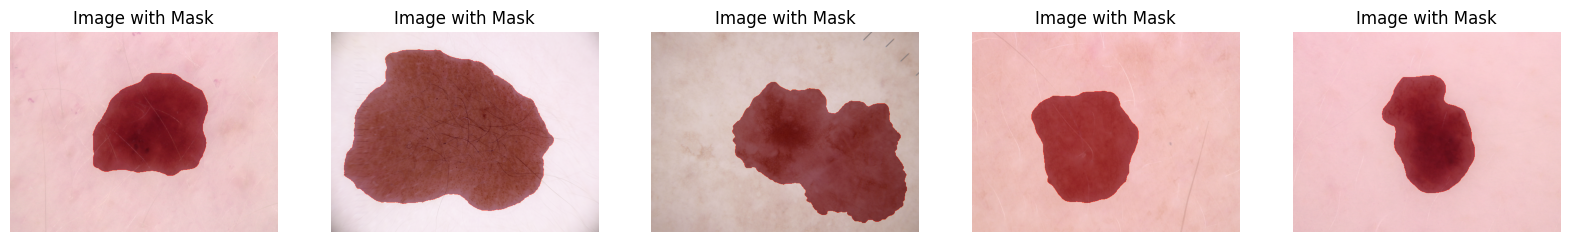

In [5]:
display_image_with_mask(n=5, seed=42)
#%%
def img_mask_paths(img_dir, mask_dir):
    img_path = sorted(gb.glob(os.path.join(img_dir, '*.jpg')))
    mask_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))
    return np.array(img_path), np.array(mask_path)

imgs_path, masks_path = img_mask_paths(images_dir, mask_dir)
#%%
# Load the dataset
dataset = "/kaggle/input/ham1000-segmentation-and-classification/"
label_path = os.path.join(dataset, "GroundTruth.csv")
labels_df = pd.read_csv(label_path)
#%%
# Create a new column 'class' that contains the class label
labels_df['class'] = labels_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

#%%
# Split dataset
train_df, temp_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'])
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
train_df.to_csv("train/metadata.csv", index=False)
val_df.to_csv("val/metadata.csv", index=False)
test_df.to_csv("test/metadata.csv", index=False)


In [6]:
#%%
# Function to save splits
def save_split(df, split_name):
    os.makedirs(split_name, exist_ok=True)
    for _, row in df.iterrows():
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/images/{row["image"]}.jpg', f'{split_name}/{row["image"]}.jpg')
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/masks/{row["image"]}_segmentation.png', f'{split_name}/{row["image"]}_mask.png')
# Save the splits
save_split(train_df, 'train')
save_split(val_df, 'val')
save_split(test_df, 'test')

#%%
print(f'Train: {len(train_df)} samples')
print(f'Validation: {len(val_df)} samples')
print(f'Test: {len(test_df)} samples')
#%%


Train: 8012 samples
Validation: 1001 samples
Test: 1002 samples


In [7]:
# Resize images and masks
resize_transform = transforms.Resize((128, 128))

def resize_and_save(split_name):
    img_dir = os.path.join(split_name, 'images')
    mask_dir = os.path.join(split_name, 'masks')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    for img_file in os.listdir(split_name):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(split_name, img_file)
            mask_path = os.path.join(split_name, img_file.replace('.jpg', '_mask.png'))

            img = Image.open(img_path)
            mask = Image.open(mask_path)
            img_resized = resize_transform(img)
            mask_resized = resize_transform(mask)

            img_resized.save(os.path.join(img_dir, img_file))
            mask_resized.save(os.path.join(mask_dir, img_file.replace('.jpg', '_mask.png')))

resize_and_save('train')
resize_and_save('val')
resize_and_save('test')
#%%

In [8]:
from torch.utils.data import Dataset

# Convert images to tensors and normalize pixel values
class HAM10k(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_t = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_t = mask_t
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '_mask.png'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.mask_t(mask)

        return image, mask
#%%
# Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
mask_transform = transforms.ToTensor()
#%%
# Create PyTorch Dataset and DataLoader
train_dataset = HAM10k('train/images', 'train/masks', transform=data_transforms, mask_t=mask_transform)
val_dataset = HAM10k('val/images', 'val/masks', transform=data_transforms,  mask_t=mask_transform)
test_dataset = HAM10k('test/images', 'test/masks', transform=data_transforms,  mask_t=mask_transform)

#%%

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#%%
cudnn.benchmark = True


In [9]:

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder use ResNet as base but capture intermediate outputs
        resnet = models.resnet34(pretrained=True)
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64 channels
        self.pool1 = resnet.maxpool
        self.encoder2 = resnet.layer1  # 64 channels
        self.encoder3 = resnet.layer2  # 128 channels
        self.encoder4 = resnet.layer3  # 256 channels
        self.encoder5 = resnet.layer4  # 512 channels

        # Decoder with skip connections
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)         # 64 channels, 1/2 resolution
        e2 = self.encoder2(self.pool1(e1))  # 64 channels, 1/4 resolution
        e3 = self.encoder3(e2)        # 128 channels, 1/8 resolution
        e4 = self.encoder4(e3)        # 256 channels, 1/16 resolution
        e5 = self.encoder5(e4)        # 512 channels, 1/32 resolution

        # Decoder with skip connections
        d5 = self.upconv5(e5)         # 256 channels, 1/16 resolution
        d5 = torch.cat([d5, e4], dim=1)  # Skip connection
        d5 = self.decoder5(d5)

        d4 = self.upconv4(d5)         # 128 channels, 1/8 resolution
        d4 = torch.cat([d4, e3], dim=1)  # Skip connection
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)         # 64 channels, 1/4 resolution
        d3 = torch.cat([d3, e2], dim=1)  # Skip connection
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)         # 32 channels, 1/2 resolution
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)         # 16 channels, original resolution
        out = self.decoder1(d1)       # 1 channel, original resolution

        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

criterion = nn.BCELoss()

def train_model(model, train_loader, val_loader, epochs=5):
    model.train()
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        total_batches = len(train_loader)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}")


        scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        model.train()

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs} Completed, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
#%%
train_model(model, train_loader, val_loader)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s] 


Epoch 1/5, Batch 0/251, Loss: 0.6723
Epoch 1/5, Batch 10/251, Loss: 0.6626
Epoch 1/5, Batch 20/251, Loss: 0.6572
Epoch 1/5, Batch 30/251, Loss: 0.6502
Epoch 1/5, Batch 40/251, Loss: 0.6462
Epoch 1/5, Batch 50/251, Loss: 0.6373
Epoch 1/5, Batch 60/251, Loss: 0.6274
Epoch 1/5, Batch 70/251, Loss: 0.6298
Epoch 1/5, Batch 80/251, Loss: 0.6301
Epoch 1/5, Batch 90/251, Loss: 0.6018
Epoch 1/5, Batch 100/251, Loss: 0.6137
Epoch 1/5, Batch 110/251, Loss: 0.5881
Epoch 1/5, Batch 120/251, Loss: 0.5909
Epoch 1/5, Batch 130/251, Loss: 0.5969
Epoch 1/5, Batch 140/251, Loss: 0.5586
Epoch 1/5, Batch 150/251, Loss: 0.5603
Epoch 1/5, Batch 160/251, Loss: 0.5679
Epoch 1/5, Batch 170/251, Loss: 0.5803
Epoch 1/5, Batch 180/251, Loss: 0.5948
Epoch 1/5, Batch 190/251, Loss: 0.5317
Epoch 1/5, Batch 200/251, Loss: 0.5786
Epoch 1/5, Batch 210/251, Loss: 0.5366
Epoch 1/5, Batch 220/251, Loss: 0.5483
Epoch 1/5, Batch 230/251, Loss: 0.5322
Epoch 1/5, Batch 240/251, Loss: 0.5843
Epoch 1/5, Batch 250/251, Loss: 0.53

In [10]:
#%%
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    dice_scores = []
    criterion = nn.BCELoss()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item()

            outputs = (outputs > 0.5).float()
            intersection = (outputs * masks).sum()
            dice_score = (2. * intersection) / (outputs.sum() + masks.sum() + 1e-8)
            dice_scores.append(dice_score.item())

    avg_loss = total_loss / len(test_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Test Loss: {avg_loss:.4f}, Average Dice Score: {avg_dice:.4f}")

    return avg_loss, avg_dice

# Run Evaluation
test_loss, test_dice = evaluate_model(model, test_loader)

Test Loss: 0.3424, Average Dice Score: 0.7020


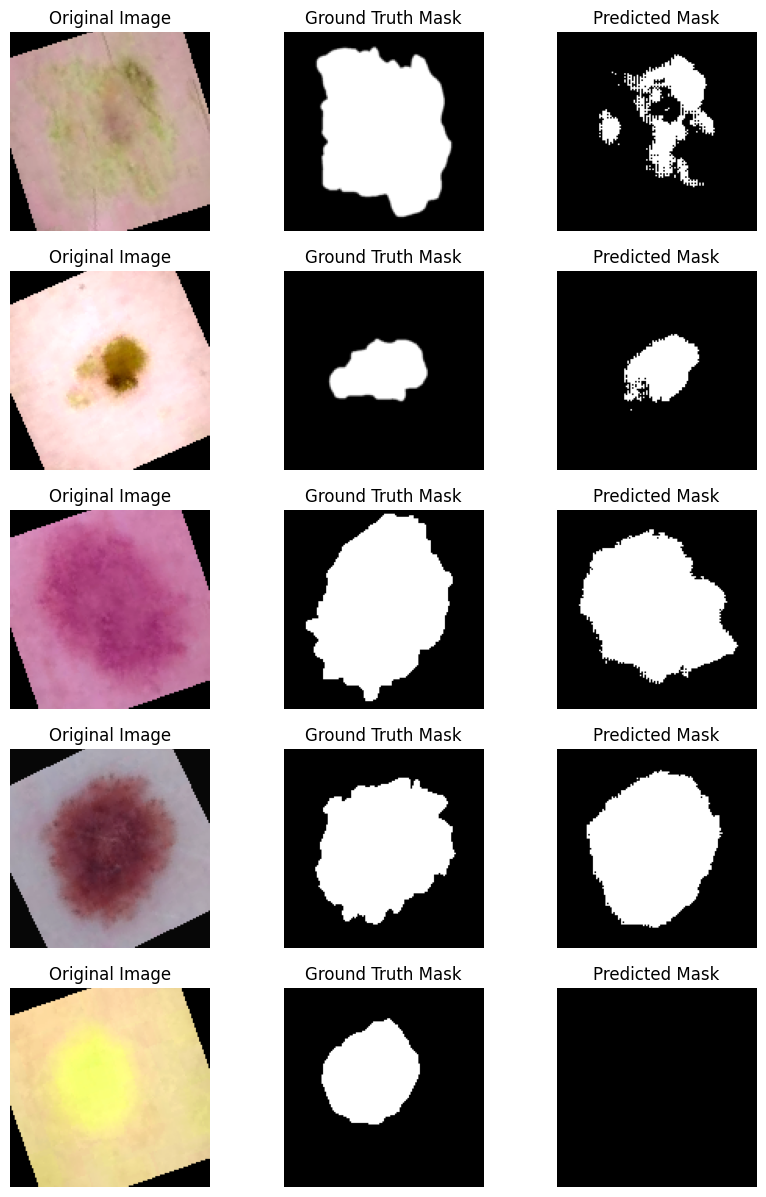

In [11]:
#%%
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def denormalize(img):
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    images, masks = next(iter(test_loader))
    images, masks = images[:num_samples].to(device), masks[:num_samples].to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = (outputs > 0.5).float()

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = images[i].cpu().unsqueeze(0)
        img = denormalize(img).squeeze(0).permute(1, 2, 0).numpy()

        mask = masks[i].cpu().squeeze().numpy()
        pred = outputs[i].cpu().squeeze().numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()

visualize_predictions(model, test_loader)

In [12]:
from torch.utils.data import Dataset

class HAM10kClassification(Dataset):
    def __init__(self, img_dir, metadata_csv, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(metadata_csv)
        self.transform = transform

        # Print columns to verify structure

        # Create a label map from the one-hot encoded columns
        self.label_map = {col: idx for idx, col in enumerate(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])}

        # Add a new column 'label_idx' to the DataFrame
        self.df['label_idx'] = self.df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1).map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'] + '.jpg')  # Assuming 'image' column contains image IDs
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['label_idx'], dtype=torch.long)
        return image, label

train_dataset = HAM10kClassification('train', 'train/metadata.csv', transform=data_transforms)
val_dataset = HAM10kClassification('val', 'val/metadata.csv', transform=data_transforms)
test_dataset = HAM10kClassification('test', 'test/metadata.csv', transform=data_transforms)

#%%

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNClassifier, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> 14x14
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # -> (B, 256, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),             # -> (B, 256)
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(num_classes=7).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
criterion = nn.CrossEntropyLoss()

def train_classifier(model, train_loader, val_loader, epochs=10):
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1} Completed — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
    def __init__(self, img_dir, labels_csv, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(labels_csv)
        self.transform = transform

        self.label_map = {label: idx for idx, label in enumerate(self.df['dx'].unique())}
        self.df['label_idx'] = self.df['dx'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'] + '.jpg')
    
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            print(f"⚠️ Skipping file: {img_path}")
            return self.__getitem__((idx + 1) % len(self.df))  # try next sample
    
        if self.transform:
            image = self.transform(image)
    
        label = torch.tensor(self.label_map[row['dx']], dtype=torch.long)
        return image, label




In [15]:
import os

missing = []
for fname in val_dataset.df['image']:
    fpath = os.path.join('val/images', fname + '.jpg')
    if not os.path.exists(fpath):
        missing.append(fpath)

print(f"Missing {len(missing)} files")
print(missing[:5])  # preview the first few missing


Missing 0 files
[]


In [ ]:
train_classifier(model, train_loader, val_loader)

Epoch 1/10, Batch 0/251, Loss: 2.0186
Epoch 1/10, Batch 10/251, Loss: 1.7880
Epoch 1/10, Batch 20/251, Loss: 1.4745
Epoch 1/10, Batch 30/251, Loss: 1.3924
Epoch 1/10, Batch 40/251, Loss: 1.1614
Epoch 1/10, Batch 50/251, Loss: 0.9374
Epoch 1/10, Batch 60/251, Loss: 1.5340
Epoch 1/10, Batch 70/251, Loss: 1.2805
Epoch 1/10, Batch 80/251, Loss: 1.0064
Epoch 1/10, Batch 90/251, Loss: 0.8962
Epoch 1/10, Batch 100/251, Loss: 1.0224
Epoch 1/10, Batch 110/251, Loss: 1.0084
Epoch 1/10, Batch 120/251, Loss: 0.8797
Epoch 1/10, Batch 130/251, Loss: 1.3295
Epoch 1/10, Batch 140/251, Loss: 0.9458
Epoch 1/10, Batch 150/251, Loss: 1.1241
Epoch 1/10, Batch 160/251, Loss: 0.8629
Epoch 1/10, Batch 170/251, Loss: 0.9627
Epoch 1/10, Batch 180/251, Loss: 1.0810
Epoch 1/10, Batch 190/251, Loss: 1.0208
Epoch 1/10, Batch 200/251, Loss: 1.2840
Epoch 1/10, Batch 210/251, Loss: 1.5652
Epoch 1/10, Batch 220/251, Loss: 0.8800
Epoch 1/10, Batch 230/251, Loss: 0.6416
Epoch 1/10, Batch 240/251, Loss: 0.9715
Epoch 1/10,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_classifier(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n Overall Test Accuracy: {accuracy * 100:.2f}%\n")

from torchvision import models
import torch.nn as nn
import torch.optim as optim

model = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for 7-class output
model.classifier[1] = nn.Linear(model.last_channel, 7)  # 7 skin classes

# Optionally unfreeze last few layers for fine-tuning
for param in model.features[-2:].parameters():
    param.requires_grad = True

model = model.to(device)

# Optimizer for only trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()
    # Classification report
    print("Classification Report:\n"from torchvision import models
import torch.nn as nn
import torch.optim as optim

model = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for 7-class output
model.classifier[1] = nn.Linear(model.last_channel, 7)  # 7 skin classes

# Optionally unfreeze last few layers for fine-tuning
for param in model.features[-2:].parameters():
    param.requires_grad = True

model = model.to(device)

# Optimizer for only trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()
)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(" Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
from torchvision import models

model = models.mobilenet_v2(pretrained=True)

# Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.last_channel, 7)  # 7 classes
model = model.to(device)


In [ ]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [ ]:
for param in model.features[-2:].parameters():  # last 2 layers
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # lower LR


In [ ]:
def evaluate(model, val_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

model = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for 7-class output
model.classifier[1] = nn.Linear(model.last_channel, 7)  # 7 skin classes

# Optionally unfreeze last few layers for fine-tuning
for param in model.features[-2:].parameters():
    param.requires_grad = True

model = model.to(device)

# Optimizer for only trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Evaluation
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mobilenetv2.pth")
            print("Best model saved.")


In [ ]:
def evaluate(model, val_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")
